In [1]:
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [3]:
# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document


class GraphState(MessagesState):
    # messages 키는 기본 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능 
    documents: List[Document]
    grade: float
    num_generation: int

In [5]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# menu db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# LLM 모델 
#llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatOpenAI(
    # api_key=OPENAI_API_KEY,
    base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = cafe_db.as_retriever(
    search_kwargs={"k": 6}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "어린이를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

## 어린이를 위한 메뉴

*   티라미수 (가격: 7,500원)

    *   주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    *   설명: 이탈리아 전통 디저트입니다. 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다. 
*   프라푸치노 (가격: 7,000원)

    *   주요 원료: 에스프레소, 우유, 얼음, 휘핑크림 
    *   설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.

해당 메뉴는 어린아이들이 좋아할 만한 부드럽고 달콤한 맛을 가진 디저트와 음료입니다.


In [6]:
'''
initial_state = {
    "messages": [HumanMessage(content=query)],
}
'''
# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    """
    주어진 상태에서 질문을 추출하고 RAG(Retrieval-Augmented Generation)를 수행하는 함수
    
    Args:
        state (GraphState): 현재 그래프 상태 객체. 다음을 포함:
            - messages: 대화 메시지 리스트 (마지막 메시지는 사용자 질문)
            
    Returns:
        dict: 업데이트된 상태 객체. 다음을 포함:
            - messages: AI 응답 메시지가 추가된 메시지 리스트
            - documents: 검색된 문서 리스트
    """
    
    # 상태에서 마지막 메시지 가져오기 (사용자의 질문)
    # state['messages']는 대화 기록을 저장하는 리스트
    last_human_message = state['messages'][-1]
    
    # HumanMessage 객체에서 실제 질문 내용 추출
    # HumanMessage는 langchain_core.messages에 정의된 사용자 메시지 클래스
    query = last_human_message.content
    
    # 벡터 저장소에서 질문과 관련된 문서 검색
    # retriever는 FAISS 벡터 저장소에서 similarity search를 수행하는 객체
    # search_kwargs={"k": 6}로 설정되어 상위 6개 문서 반환
    retrieved_docs = retriever.invoke(query)
    
    # RAG 체인을 사용하여 응답 생성
    # rag_chain은 다음으로 구성된 체인:
    # 1. 검색된 문서를 context로 변환
    # 2. 사용자 질문과 결합
    # 3. LLM 모델로 전달하여 응답 생성
    # 4. 문자열 파싱
    response = rag_chain.invoke(query)
    
    # 데이트된 상태 반환
    return {
        # 기존 메시지에 AI 응답 메시지 추가
        # AIMessage는 langchain_core.messages에 정의된 AI 응답 메시지 클래스
        "messages": [AIMessage(content=response)],
        # 검색된 문서 저장 (나중에 답변 평가에 사용)
        # documents는 langchain_core.documents.Document 객체 리스트
        "documents": retrieved_docs
    }

In [8]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    """
    현재 답변의 품질을 평가하여 재시도 여부를 결정하는 함수
    
    Args:
        state (GraphState): 현재 상태 객체
            - grade: 최근 답변의 평가 점수 (0~1)
            - num_generation: 답변 생성 시도 횟수
            
    Returns:
        "retrieve_and_respond" or "generate":
            - "retrieve_and_respond": 답변 재생성 필요 (RAG 프로세스 다시 실행)
            - "generate": 현재 답변으로 충분 (프로세스 종료)
    """
    
    # 디버깅을 위한 평가 점수 출력
    print("----평가 결과 확인----")
    print("현재 점수:", state["grade"])
    print("생성 시도 횟수:", state["num_generation"])

    # 1. 최대 시도 횟수 확인 (3회 이상이면 중단)
    if state["num_generation"] > 2:
        print("※ 최대 시도 횟수(3회) 도달 - 프로세스 종료")
        return "generate"  # 더 이상 시도하지 않음
    
    # 2. 점수 평가 (0.7 미만이면 재시도)
    if state["grade"] < 0.7:
        print("※ 점수 미달(0.7 미만) - 답변 재생성 필요")
        return "retrieve_and_respond"  # RAG 프로세스 재실행
    else:
        print("※ 충분한 점수(0.7 이상) - 프로세스 완료")
        return "generate"  # 현재 답변으로 만족

In [11]:

from pydantic import BaseModel, Field

# 답변 평가 결과를 위한 데이터 모델 정의
class GradeResponse(BaseModel):
    "A score for answers"
    # 점수 (0~1 사이 값, 1이 최고점)
    score: float = Field(
        ...,  # 필수 항목
        ge=0,  # 최소값 0
        le=1,  # 최대값 1 
        description="0에서 1 사이의 점수, 1은 완벽한 답변"
    )
    # 평가 설명
    explanation: str = Field(
        ...,  # 필수 항목
        description="주어진 점수에 대한 설명"
    )
    
# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    """
    AI의 답변을 평가하여 점수를 매기는 함수
    
    Args:
        state (GraphState): 현재 상태 객체
            - messages: 대화 기록 (마지막 두 메시지: [질문, 답변])
            - documents: 참고 문서
            
    Returns:
        dict: 업데이트된 상태
            - grade: 평가 점수 (0~1)
            - num_generation: 답변 생성 횟수
    """
    
    # 대화 기록에서 질문과 답변 추출
    messages = state['messages']
    # 마지막에서 두번째 메시지(사용자 질문)
    question = messages[-2].content
    # 마지막 메시지(AI 답변)
    answer = messages[-1].content
    # 참고 문서를 문자열로 변환
    context = format_docs(state['documents'])
    
    # 평가자 역할을 정의하는 시스템 프롬프트
    grading_system = """
    당신은 전문 평가자입니다.
    주어진 컨텍스트를 고려하여 답변의 정확성과 관련성을 평가하세요.
    0에서 1 사이의 점수(1이 완벽)와 설명을 제공하세요.
    """

    # 평가를 위한 프롬프트 템플릿 생성
    grading_prompt = ChatPromptTemplate.from_messages([
        # 평가자 역할 설정
        ("system", grading_system),
        ("human", 
         "[질문]\n{question}\n\n"    # 사용자 질문
         "[컨텍스트]\n{context}\n\n"  # 참고 문서
         "[답변]\n{answer}\n\n"       # AI 답변
         "[평가]\n")                  # 평가 요청
        #("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    try:
        # 평가 체인 구성: 프롬프트 → LLM → 구조화된 출력
        grading_chain = grading_prompt | llm.with_structured_output(
            schema=GradeResponse  # 출력 형식 지정
        )
        # 실제 평가 수행
        grade_response = grading_chain.invoke({
            "question": question,
            "context": context,
            "answer": answer
        })
        
        # 점수 범위 보정 (0~1 사이로 강제 조정)
        score = max(0, min(1, grade_response.score))  # Clamp between 0 and 1
        
    except Exception as e:
        # 평가 실패 시 처리
        print(f"Error during grading: {e}")
        # 기본 점수
        score = 0.5
        grade_response = GradeResponse(
            score=score, 
            explanation="평가 과정에서 오류가 발생했습니다"
        )

    # 답변 생성 횟수 업데이트 (초기값 0)
    num_generation = state.get('num_generation', 0)
    # 횟수 증가
    num_generation += 1
    
    return {
        # 평가 점수
        "grade": score, 
        # 생성 횟수
        "num_generation": num_generation}

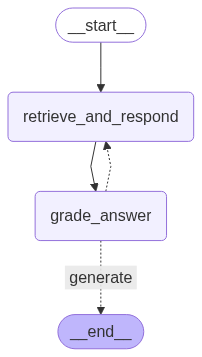

In [13]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 설정
builder = StateGraph(GraphState)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

builder.add_edge(START, "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 초기 상태
#query = "채식주의자를 위한 메뉴를 추천해주세요."
query = "어린이를 위한 음료와 디저트를 추천해주세요."

initial_state = {
    "messages": [HumanMessage(content=query)],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:\n")
pprint(final_state)

Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----평가 결과 확인----
현재 점수: 0.5
생성 시도 횟수: 1
※ 점수 미달(0.7 미만) - 답변 재생성 필요
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----평가 결과 확인----
현재 점수: 0.5
생성 시도 횟수: 2
※ 점수 미달(0.7 미만) - 답변 재생성 필요


In [ ]:
# 최종 답변만 출력
pprint(final_state['messages'][-1].content) 